In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from MLP import *
from CustomDataset import *


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on {device}')

Working on cpu


In [4]:
data_np = pd.read_csv('concrete.csv', header=None).values
train, test = train_test_split(data_np, test_size = 0.2, shuffle=True, random_state=0)

In [5]:
train_2, val = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
train_2_scaler = StandardScaler()
train_2[:, :-1] = train_2_scaler.fit_transform(train_2[:, :-1])
val[:, :-1] = train_2_scaler.transform(val[:, :-1])

train_2_set = CustomDataset(train_2)
val_set = CustomDataset(val)

train_2_loader = DataLoader(train_2_set, batch_size = 32)
val_loader = DataLoader(val_set, batch_size = 32)

In [6]:
momentum_terms = {
    0 : 0.001,
    1 : 0.003,
    2 : 0.006,
    3 : 0.01
}

models = [[[MLP(8, 4**i, 1), None] for i in range(4)] for j in range(4)]
criterion = torch.nn.MSELoss()
for i in range(4):
    for j in range(4):
        models[i][j][1] = torch.optim.SGD(models[i][j][0].parameters(), lr = 0.001, momentum = momentum_terms[j])

In [7]:
loss_list = [[[list() for i in range(4)] for j in range(4)] for k in range(2)]

In [8]:
for i in range(4):
    for j in range(4):
        for epoch in range(400):
            for index, (attributes, labels) in enumerate(train_2_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)
                
                outputs = models[i][j][0](attributes)
                loss = criterion(outputs[:, 0], labels)
                
                models[i][j][1].zero_grad()
                loss.backward()
                models[i][j][1].step()
            
            loss_list[0][i][j].append(loss.item())

            for index, (attributes, labels) in enumerate(val_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)

                outputs = models[i][j][0](attributes)
                loss = criterion(outputs[:, 0], labels)
            
            loss_list[1][i][j].append(loss.item())

        print(f'Model with {4**i} neurons and momentum rate = {momentum_terms[j]} trained.')

Model with 1 neurons and momentum rate = 0.001 trained.
Model with 1 neurons and momentum rate = 0.003 trained.
Model with 1 neurons and momentum rate = 0.006 trained.
Model with 1 neurons and momentum rate = 0.01 trained.
Model with 4 neurons and momentum rate = 0.001 trained.
Model with 4 neurons and momentum rate = 0.003 trained.
Model with 4 neurons and momentum rate = 0.006 trained.
Model with 4 neurons and momentum rate = 0.01 trained.
Model with 16 neurons and momentum rate = 0.001 trained.
Model with 16 neurons and momentum rate = 0.003 trained.
Model with 16 neurons and momentum rate = 0.006 trained.
Model with 16 neurons and momentum rate = 0.01 trained.
Model with 64 neurons and momentum rate = 0.001 trained.
Model with 64 neurons and momentum rate = 0.003 trained.
Model with 64 neurons and momentum rate = 0.006 trained.
Model with 64 neurons and momentum rate = 0.01 trained.


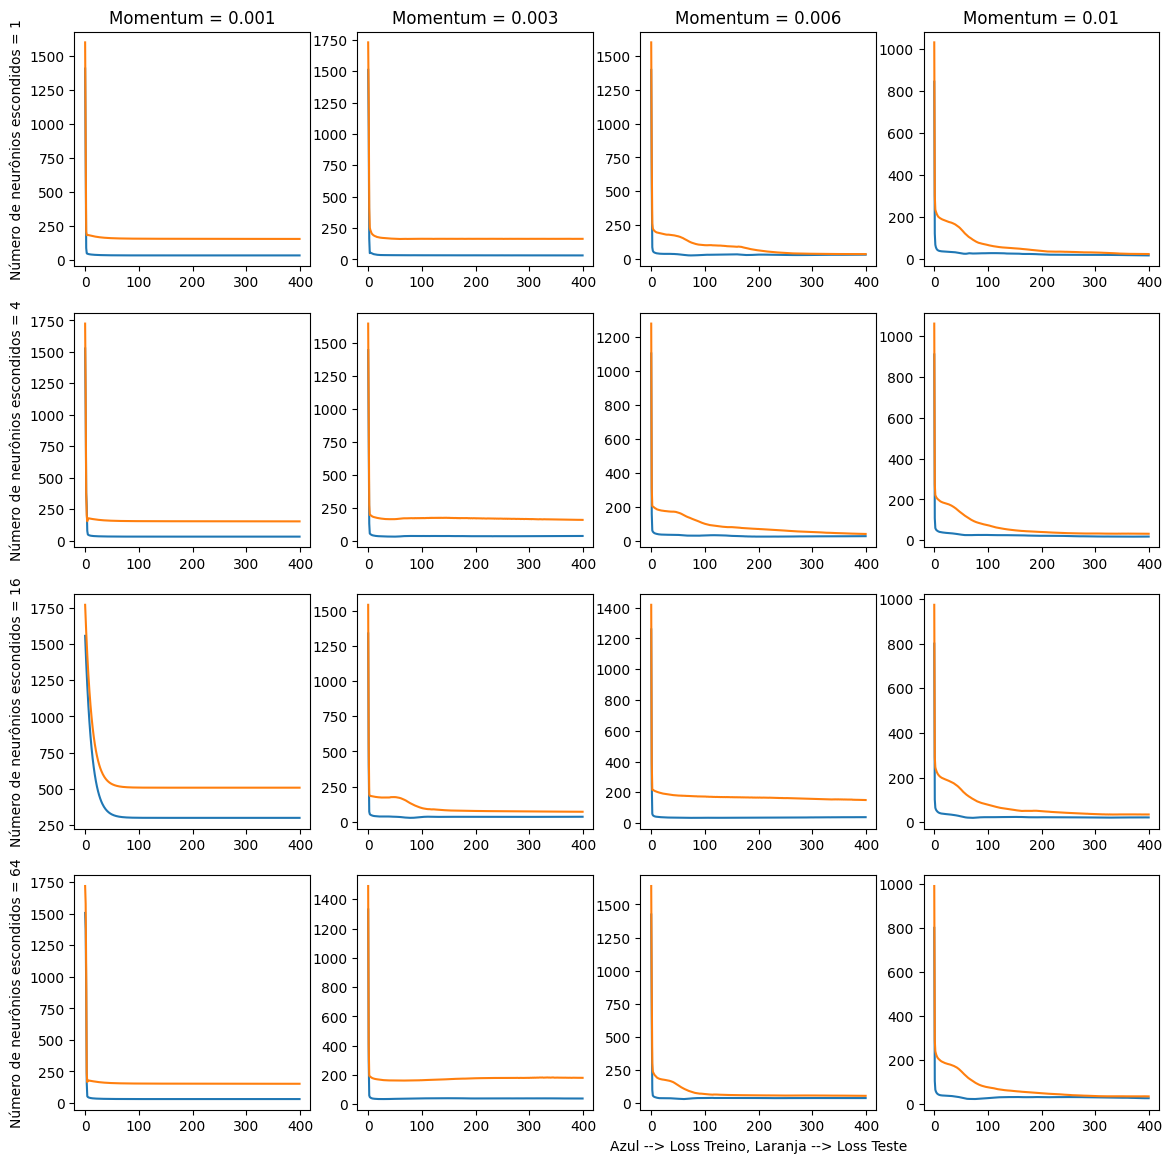

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(14, 14))

for i in range(4):
    for j in range(4):
        ax[i][j].plot(range(len(loss_list[0][i][j])), loss_list[0][i][j])
        ax[i][j].plot(range(len(loss_list[1][i][j])), loss_list[1][i][j])

for i in range(4):
    ax[0][i].set_title(f'Momentum = {momentum_terms[i]}')
    ax[i][0].set_ylabel(f'Número de neurônios escondidos = {4**i}')

ax[-1][-2].set_xlabel('Azul --> Loss Treino, Laranja --> Loss Teste')

plt.show()

In [10]:
train_rmse = np.zeros((4, 4))
train_mae = np.zeros((4, 4))
val_rmse = np.zeros((4, 4))
val_mae = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        train_out = models[i][j][0](torch.from_numpy(train_2[:, :-1]).to(torch.float32))
        train_real = torch.from_numpy(train_2[:, -1]).to(torch.float32)

        val_out = models[i][j][0](torch.from_numpy(val[:, :-1]).to(torch.float32))
        val_real = torch.from_numpy(val[:, -1]).to(torch.float32)

        train_rmse[i][j] = torch.sqrt(torch.nn.functional.mse_loss(train_out, train_real.reshape(-1, 1)))
        train_mae[i][j] = torch.nn.functional.l1_loss(train_out, train_real.reshape(-1, 1))

        val_rmse[i][j] = torch.sqrt(torch.nn.functional.mse_loss(val_out, val_real.reshape(-1, 1)))
        val_mae[i][j] = torch.nn.functional.l1_loss(val_out, val_real.reshape(-1, 1))


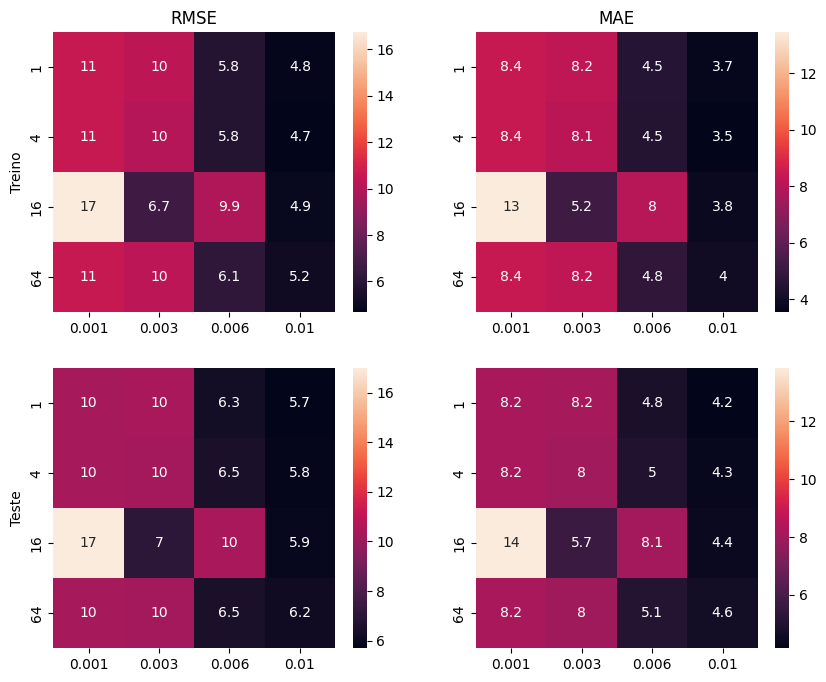

In [11]:
ylabels = [f'{4**i}' for i in range(4)]
xlabels = [f'{momentum_terms[i]}' for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

rmse_val = sns.heatmap(train_rmse, annot=True, ax=ax[0][0], xticklabels=xlabels, yticklabels=ylabels)
mae_val = sns.heatmap(train_mae, annot=True, ax=ax[0][1], xticklabels=xlabels, yticklabels=ylabels)
rmse_val = sns.heatmap(val_rmse, annot=True, ax=ax[1][0], xticklabels=xlabels, yticklabels=ylabels)
mae_val = sns.heatmap(val_mae, annot=True, ax=ax[1][1], xticklabels=xlabels, yticklabels=ylabels)

ax[0][0].set_title('RMSE')
ax[0][1].set_title('MAE')
ax[0][0].set_ylabel('Treino')
ax[1][0].set_ylabel('Teste')

plt.show()

In [12]:
train_scaler = StandardScaler()
train[:, :-1] = train_scaler.fit_transform(train[:, :-1])
test[:, :-1] = train_scaler.transform(test[:, :-1])

train_set = CustomDataset(train)
test_set = CustomDataset(test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [13]:
model = MLP(8, 4, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.1)

In [14]:
loss_list = [list() for i in range(2)]

In [15]:
for epoch in range(100):
    for index, (attributes, labels) in enumerate(train_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)
        
        outputs = model(attributes)
        loss = criterion(outputs[:, 0], labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_list[0].append(loss.item())

    for index, (attributes, labels) in enumerate(test_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)

        outputs = model(attributes)
        loss = criterion(outputs[:, 0], labels)
    
    loss_list[1].append(loss.item())

    print(f'Epoch {epoch+1}/100, Train Loss: {loss_list[0][-1]}, Test Loss: {loss_list[1][-1]}')

Epoch 1/100, Train Loss: 1951.5123291015625, Test Loss: 1267.3135986328125
Epoch 2/100, Train Loss: 304.69635009765625, Test Loss: 177.16285705566406
Epoch 3/100, Train Loss: 172.27235412597656, Test Loss: 64.91976165771484
Epoch 4/100, Train Loss: 67.06124114990234, Test Loss: 140.65370178222656
Epoch 5/100, Train Loss: 133.8756866455078, Test Loss: 91.28187561035156
Epoch 6/100, Train Loss: 133.6249237060547, Test Loss: 64.9916000366211
Epoch 7/100, Train Loss: 79.66016387939453, Test Loss: 147.81369018554688
Epoch 8/100, Train Loss: 69.85808563232422, Test Loss: 136.37057495117188
Epoch 9/100, Train Loss: 138.37994384765625, Test Loss: 82.86375427246094
Epoch 10/100, Train Loss: 142.97100830078125, Test Loss: 101.9747314453125
Epoch 11/100, Train Loss: 112.68990325927734, Test Loss: 61.0177001953125
Epoch 12/100, Train Loss: 109.30269622802734, Test Loss: 72.64024353027344
Epoch 13/100, Train Loss: 103.4454345703125, Test Loss: 63.906803131103516
Epoch 14/100, Train Loss: 140.000869

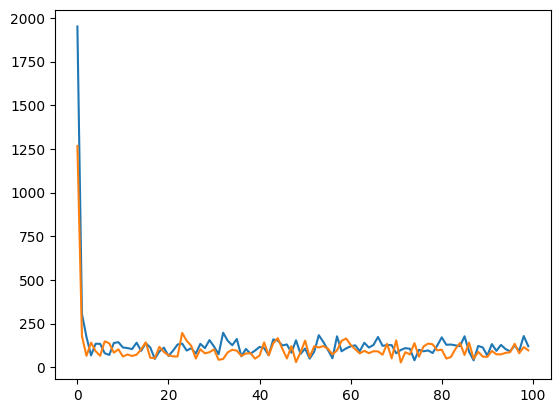

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_list[0])), loss_list[0])
plt.plot(range(len(loss_list[1])), loss_list[1])
plt.show()

In [25]:
metrics = np.zeros((2, 2))

train_out = model(torch.from_numpy(train[:, :-1]).to(torch.float32))
train_real = torch.from_numpy(train[:, -1]).to(torch.float32).reshape(-1, 1)
test_out = model(torch.from_numpy(test[:, :-1]).to(torch.float32))
test_real = torch.from_numpy(test[:, -1]).to(torch.float32).reshape(-1, 1)

metrics[0][0] = torch.sqrt(torch.nn.functional.mse_loss(train_out, train_real))
metrics[0][1] = torch.nn.functional.l1_loss(train_out, train_real)
metrics[1][0] = torch.sqrt(torch.nn.functional.mse_loss(test_out, test_real))
metrics[1][1] = torch.nn.functional.l1_loss(test_out, test_real)


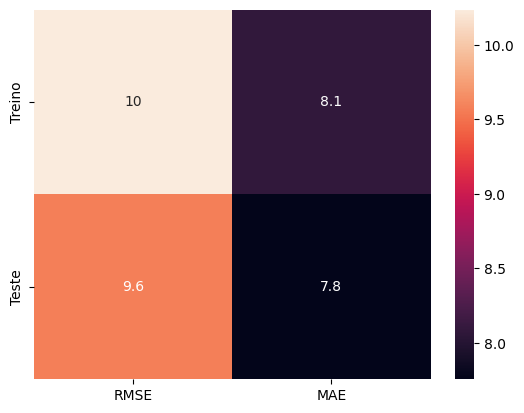

In [28]:
xlabels = ['RMSE', 'MAE']
ylabels = ['Treino', 'Teste']

hm = sns.heatmap(metrics, annot=True, xticklabels=xlabels, yticklabels=ylabels)